In [5]:
#import packages that have the tools we need
import numpy as np 
import pandas as pd 
import csv

wage = pd.read_csv("Data/wage.csv")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=4, include_bias=False)

X=wage[['age']]
y= wage['wage']


model = LinearRegression()

model.fit(poly.fit_transform(X), y)

#coefficients
model.intercept_, model.coef_

model.intercept_



-184.1541797741471

In [6]:
#we need the standard error, and Sklearn doesn't supply it

import statsmodels.formula.api as smf

results = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit()

results.summary()

results.bse

results.conf_int()

,0,1
Intercept,-301.878732,-6.642963e+01
age,9.703041,3.278800e+01
"np.power(age, 2)",-0.967987,-1.597312e-01
"np.power(age, 3)",0.000799,1.282223e-02
"np.power(age, 4)",-0.000064,1.447431e-07


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           2.77e-57
Time:                        18:03:05   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -184.1542     60.040     -3.067      0.002    -301.879     -66.430
age                 21.2455      5.887      3.609      0.000       9.703      32.788
np.power(age, 2)    -0.5639      0.206     -2.736      0.006      -0.968      -0.160
np.power(age, 3)     0.0068      0.003      2.221      0.026       0.001       0.013
np.power(age, 4) -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

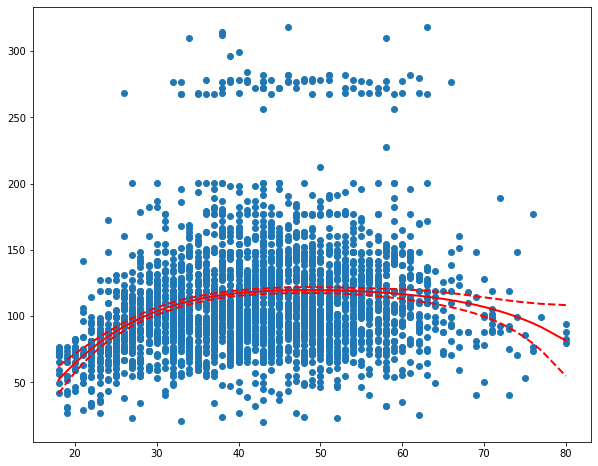

In [7]:
#Confidence interval for the mean(regression line) and prediction. Predeiciton intervals will be much wider. Regression shouldnt move much.
from statsmodels.stats.outliers_influence import summary_table
st, data, ss2 = summary_table(results, alpha=0.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

order = np.argsort(X.values.flatten())
x_o = X.values.flatten()[order]

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.scatter(x_o, y[order])
plt.plot(x_o, fittedvalues[order], 'r', lw=2)
plt.plot(x_o, predict_mean_ci_low[order], 'r--', lw=2)
plt.plot(x_o, predict_mean_ci_upp[order], 'r--', lw=2)

#which features are neccessary
smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit().summary()

In [8]:
#use Anova to test whether each additional polynomial term is significant
from statsmodels.stats.api import anova_lm
mod1 = smf.ols('wage ~ age', data=wage).fit()
mod2 = smf.ols('wage ~ age + np.power(age, 2)', data=wage).fit()
mod3 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3)', data=wage).fit()
mod4 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit()
mod5 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4) + np.power(age, 5)', data=wage).fit()

#polynomial terms 4 and 5 are not needed, p >0.5
anova_lm(mod1, mod2, mod3, mod4, mod5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


(0, 0.07)

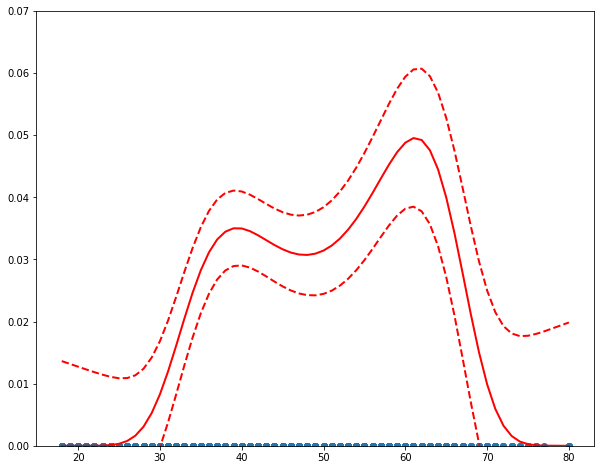

In [9]:
#prediction of greater than 250k income Logistic regression :)
wage['wage_250'] = (wage['wage'] > 250) * 1
results = smf.logit('wage_250 ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit()


results.summary()

y_hat = np.exp(results.fittedvalues)
y = wage['wage_250'].values
x = X['age'].values
x_mean = x.mean()
n = len(y)

sy = np.sqrt(np.sum((y - y_hat)**2) / (n - 2))
sx = np.sum((x - x_mean) ** 2) / n
x_s = (x - x_mean) ** 2

sx = np.sum(x ** 2) - (x.sum() ** 2) / n

err = sy * np.sqrt(1/n + x_s / x_s.sum())

order = np.argsort(x)
x_o = x[order]

plt.figure(figsize=(10, 8))
plt.scatter(x_o, y[order])
plt.plot(x_o, y_hat[order], 'r', lw=2)
plt.plot(x_o, y_hat[order] + 2 * err[order], 'r--', lw=2)
plt.plot(x_o, y_hat[order] - 2 * err[order], 'r--', lw=2)
plt.ylim(0, .07)

In [10]:
#Step function using pd.cut

results = smf.ols('wage ~ pd.cut(age, 4)', data=wage).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.58
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           1.13e-41
Time:                        18:05:56   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 94.1584      1.476     63.790      0.000      91.264      97.053
pd.cut(age, 4)[T.Interval(33.5, 49.0, closed='right')]    24.0535      1.829     13.148      0.000      20.466      27.641
pd.cut(age, 4)[T.Interval(49.0, 64.5, closed='right')]    23.6646      2.068     11.443      0.000      19.610      27.719
pd.cut(age, 4)[T.Interval(64.5, 80.0, closed='right')]     7.6406      4.987      1.532      0.126      -2.139      17.420
==============================================================================
Omnibus:                     1062.354   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4551.200
Skew:                           1.681   Prob(JB):                         0.00
Kurtosis:                       8.011   Cond. No.                         7.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
#Splines
import scipy.interpolate as si

y = wage['wage'].values

order = np.argsort(x)

x_sort = x[order]
y_sort = y[order]
t = np.array([25, 40, 60])

spl = si.LSQUnivariateSpline(x_sort, y_sort, t)
spl(x_sort)

plt.figure(figsize=(10,8))
plt.plot(x_sort, y_sort, 'ro', ms=5)
plt.plot(x_sort, spl(x_sort), 'g-', lw=3)



ValueError: x must be strictly increasing